# 1. Introduction

**Silicon Valley** happens to be the most recent TV show that I have binged upon and I became a fan right off the bat. Everything from the content, plot, play etc appealed to me. 




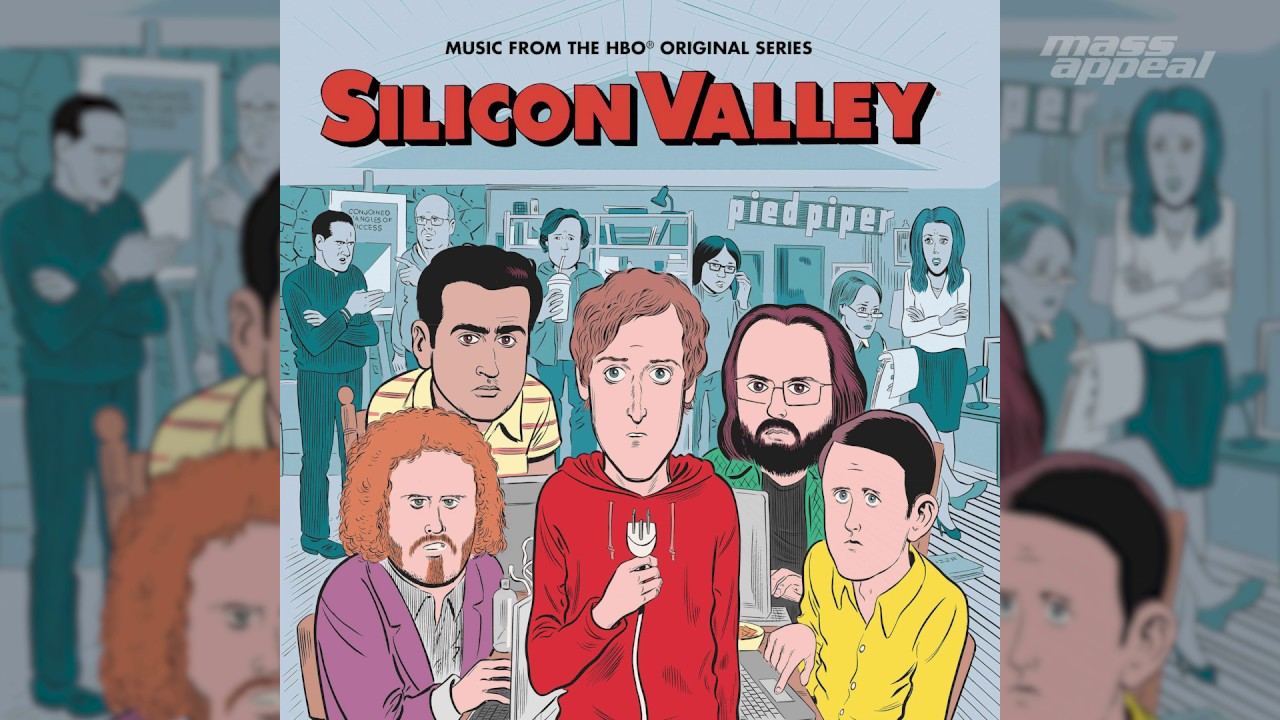








For those of you, who haven't seen the show , this is a journey of a group of techies trying to build something using their tech-ablilities. This group reminded me of a similar(yet very diffenernt) group of guys from another TV show called *The Bing Bang Theory (TBBT)* which was also a very popular seires. Personally, I hated TBBT (I'm sorry !) even though there is similar core theme to both the shows.  

So, in this project I have tried to use **Natural Language Processing(NLP)** to figure out how Silicon Valley is diffenent from TBBT and whether the language used has affected my preferences.

We'll try to answer the following questions : 

    1. What kind of langage is used in Silicon Valley ?
    2. What sentiment does Silicon Valley carry on Twitter ?
    3. Comparison between the languages of Silicon Valley and TBBT.

# 2. Data Collection and Data Cleaning

##  2.1 Data Collection

Our data is going to be transcripts of the show. Guys at  https://www.springfieldspringfield.co.uk/  have done a wonderful job in making transcripts for all the episodes. We will be using all the transcripts for the Season 1. (total 8 episodes so 8 transcripts).

In order to collect data we will be doing some web scraping using the Beautiful Soup package for parsing HTML and XML documents in python. 

[Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)

In [1]:
#Importing packages

import requests
from bs4 import BeautifulSoup
import pickle
from requests import get

In [2]:
#Creating a list of links to scrape

urls = []
for i in range(1,9):
    url = 'https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e0'+str(i)
    urls.append(url)
    
urls

['https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e01',
 'https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e02',
 'https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e03',
 'https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e04',
 'https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e05',
 'https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e06',
 'https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e07',
 'https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e08']

In [3]:
#Perform scraping 

def url_to_transcript(url):
    page = requests.get(url).text
    soup = BeautifulSoup(page, "lxml")
    text = [soup.find('div','scrolling-script-container').text]
    print(url)
    return text

In [4]:
#Storing all the transcripts in a list. This is the raw data on which we have to work. Very Unclean. Sigh ! 

transcripts = [url_to_transcript(u) for u in urls]
transcripts

https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e01
https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e02
https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e03
https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e04
https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e05
https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e06
https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e07
https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e08


[['\r\n\r\n\r\n                    \t\t\t Whoo. Yeah. Somebody make some motherfucking noise in here! Fuck these people. Man, this place is unbelievable. Fucking Goolybib, man. Those guys build a mediocre piece of software, that might be worth something someday, and now they live here. There\'s money flying all over Silicon Valley but none of it ever seems to hit us. What the hell are you eating? Liquid shrimp. It\'s 200 dollars a quart. Wylie Dufresne made it. How does it taste? Like how I would imagine cum tastes. You guys taking it all in? Because this is what it looks like when Google acquires your company for over 200 million dollars. Look Dustin Moskovitz. Elon Musk. Eric Schmidt. Whatever the fuck the guy\'s name is who created Photrio. I mean, Kid Rock is the poorest person here. Apart from you guys. Ok, there\'s 40 billion dollars of net worth, walking around this party. And you guys are standing around drinking shrimp and talking about what cum tastes like. Yeah, I heard that

In [5]:
#Creating a list of episodes for easy reference

episodes  = []
for k in range(1,9):
    ep = 'e'+str(k)
    episodes.append(ep)
    
episodes

['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8']

In [6]:
#Creating a dictionary for easy readability (episode:transcript)

data_dict = {k:v for k,v in zip(episodes,transcripts)}
data_dict

{'e1': ['\r\n\r\n\r\n                    \t\t\t Whoo. Yeah. Somebody make some motherfucking noise in here! Fuck these people. Man, this place is unbelievable. Fucking Goolybib, man. Those guys build a mediocre piece of software, that might be worth something someday, and now they live here. There\'s money flying all over Silicon Valley but none of it ever seems to hit us. What the hell are you eating? Liquid shrimp. It\'s 200 dollars a quart. Wylie Dufresne made it. How does it taste? Like how I would imagine cum tastes. You guys taking it all in? Because this is what it looks like when Google acquires your company for over 200 million dollars. Look Dustin Moskovitz. Elon Musk. Eric Schmidt. Whatever the fuck the guy\'s name is who created Photrio. I mean, Kid Rock is the poorest person here. Apart from you guys. Ok, there\'s 40 billion dollars of net worth, walking around this party. And you guys are standing around drinking shrimp and talking about what cum tastes like. Yeah, I hear

## 2.2 Data Cleaning

Before cleaning our data, we will be storing it in a DataFrame since it's easier to manipulate in that format. We'll be making use of Pandas library for this purpose.<br> 
[Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/)

For string manipulation we will be making use of re(Regular expression) and string libraries. <br>
[re Documentation](https://docs.python.org/3/library/re.html)<br>
[String Documentation](https://docs.python.org/3/library/string.html)

In [7]:
#Importing packages

import pandas as pd
import re
import string

In [8]:
#Creating a dataframe

df = pd.DataFrame.from_dict(data_dict).transpose()
df.columns = ['transcripts']
df

,transcripts
e1,\r\n\r\n\r\n \t\t\t Whoo. Y...
e2,\r\n\r\n\r\n \t\t\t Holy sh...
e3,\r\n\r\n\r\n \t\t\t The gre...
e4,\r\n\r\n\r\n \t\t\t Richie!...
e5,\r\n\r\n\r\n \t\t\t It's a ...
e6,\r\n\r\n\r\n \t\t\t Kidney ...
e7,\r\n\r\n\r\n \t\t\t The cor...
e8,\r\n\r\n\r\n \t\t\t I'll ri...


In [9]:
#Quick check of the dataframe to see if things look right

df.loc['e1', 'transcripts']

'\r\n\r\n\r\n                    \t\t\t Whoo. Yeah. Somebody make some motherfucking noise in here! Fuck these people. Man, this place is unbelievable. Fucking Goolybib, man. Those guys build a mediocre piece of software, that might be worth something someday, and now they live here. There\'s money flying all over Silicon Valley but none of it ever seems to hit us. What the hell are you eating? Liquid shrimp. It\'s 200 dollars a quart. Wylie Dufresne made it. How does it taste? Like how I would imagine cum tastes. You guys taking it all in? Because this is what it looks like when Google acquires your company for over 200 million dollars. Look Dustin Moskovitz. Elon Musk. Eric Schmidt. Whatever the fuck the guy\'s name is who created Photrio. I mean, Kid Rock is the poorest person here. Apart from you guys. Ok, there\'s 40 billion dollars of net worth, walking around this party. And you guys are standing around drinking shrimp and talking about what cum tastes like. Yeah, I heard that. 

Data Cleaning can be a long process. However, as a first pass I will be performing the following steps in prder to clean the data : 
        1. Convert all text to lowercase
        2. Remove whitespace characters
        3. Remove punctuation marks
        4. Remove terms containing numbers

In [10]:
# Making a function to peroform the above mentioned steps

def clean_text_pass1(text):
    text = text.lower()               
    text = re.sub('\s+',' ',text)     
    text = re.sub('[%s]' %re.escape(string.punctuation) , '', text)     
    text = re.sub('\w*\d\w*', '', text)                          
    return text
    

In [11]:
# Checking if it works well

clean_text_pass1(df.loc['e1', 'transcripts'])

' whoo yeah somebody make some motherfucking noise in here fuck these people man this place is unbelievable fucking goolybib man those guys build a mediocre piece of software that might be worth something someday and now they live here theres money flying all over silicon valley but none of it ever seems to hit us what the hell are you eating liquid shrimp its  dollars a quart wylie dufresne made it how does it taste like how i would imagine cum tastes you guys taking it all in because this is what it looks like when google acquires your company for over  million dollars look dustin moskovitz elon musk eric schmidt whatever the fuck the guys name is who created photrio i mean kid rock is the poorest person here apart from you guys ok theres  billion dollars of net worth walking around this party and you guys are standing around drinking shrimp and talking about what cum tastes like yeah i heard that you guys live in my incubator youve got to network thats why i brought you here i got u

In [12]:
#looks good. So we'll apply the function on our dataset

data = df.transcripts.apply(clean_text_pass1)
data

e1     whoo yeah somebody make some motherfucking no...
e2     holy shit  uh  what the fuck is that uh that ...
e3     the greatness of human accomplishment has alw...
e4     richie  right on time  hey youre the lawyer r...
e5     its a fucking sketchy neighborhood man you se...
e6     kidney function liver function testosterone i...
e7     the core compression algorithm is optimal all...
e8     ill rip your dick off you son of a bitch my e...
Name: transcripts, dtype: object

## 2.2.1 Organizing the data 

For analysis purpose we need our data to be arranged in two formats.
   1. **Corpus** - A collection of text
   2. **Document-Term Matrix** - Word count in matrix format

### Corpus

In [13]:
#The clean dataframe created above is our corpus

data = pd.DataFrame(data) 
data                                         

,transcripts
e1,whoo yeah somebody make some motherfucking no...
e2,holy shit uh what the fuck is that uh that ...
e3,the greatness of human accomplishment has alw...
e4,richie right on time hey youre the lawyer r...
e5,its a fucking sketchy neighborhood man you se...
e6,kidney function liver function testosterone i...
e7,the core compression algorithm is optimal all...
e8,ill rip your dick off you son of a bitch my e...


### Document-Term Matrix

In order to create our Document-Term Matrix we will be using CountVectorizer module from scikit-Learn. This will help us in tokenizing the dataset and creating a matrix where each row represents a different document and each column represents a different word. The values in the matrix represent the number of times the word has appeared in the corresponding document. 

[CountVectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)


In [14]:

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data.transcripts)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data.index
data_dtm

,abide,ability,able,abound,abrupt,absolutely,absurd,abuse,abuzz,accept,...,yup,zenella,zero,zeroes,zeros,zimmerman,zips,zone,zones,zuckerberg
e1,0,0,2,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
e2,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
e3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
e4,0,0,4,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
e5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
e6,1,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
e7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,0
e8,0,1,2,0,0,2,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0


## 3. Exploratory Data Analysis 

In this section, our aim is to get some insights about the dataset which we cleaned in the previous section. 

We will find the most common words and represent it using *matplotlib* and *wordclouds* modules to get an idea about the topics around which the conversation revolves in the show. Later on, we can do the same for TBBT and compare the difference in languages, if any. 

[Matplotlib Documentation](https://matplotlib.org/)<br>
[Word Cloud Documentation](https://amueller.github.io/word_cloud/)

In [15]:
data_t = data_dtm.T
data_t.head()

,e1,e2,e3,e4,e5,e6,e7,e8
abide,0,0,0,0,0,1,0,0
ability,0,0,0,0,0,0,0,1
able,2,0,0,4,0,1,0,2
abound,0,0,0,0,0,1,0,0
abrupt,0,0,0,1,0,0,0,0


In [16]:
# Top 10 words in each episode


top_dict = {}
for c in data_t.columns:
    top = data_t[c].sort_values(ascending=False).head(10)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'e1': [('just', 36),
  ('know', 33),
  ('like', 30),
  ('yeah', 30),
  ('im', 27),
  ('dont', 25),
  ('ok', 21),
  ('richard', 19),
  ('right', 17),
  ('uh', 16)],
 'e2': [('just', 37),
  ('know', 36),
  ('im', 30),
  ('like', 27),
  ('dont', 24),
  ('yeah', 23),
  ('richard', 22),
  ('hes', 21),
  ('uh', 19),
  ('youre', 19)],
 'e3': [('just', 31),
  ('im', 30),
  ('pied', 28),
  ('piper', 27),
  ('ok', 23),
  ('richard', 22),
  ('like', 22),
  ('dont', 19),
  ('know', 18),
  ('better', 18)],
 'e4': [('know', 35),
  ('like', 32),
  ('just', 30),
  ('ok', 30),
  ('yeah', 28),
  ('oh', 26),
  ('im', 23),
  ('right', 22),
  ('uh', 19),
  ('dont', 19)],
 'e5': [('just', 44),
  ('know', 37),
  ('dont', 30),
  ('right', 26),
  ('im', 24),
  ('yeah', 22),
  ('like', 21),
  ('think', 21),
  ('oh', 20),
  ('thats', 18)],
 'e6': [('ok', 26),
  ('im', 23),
  ('just', 23),
  ('yeah', 20),
  ('know', 20),
  ('oh', 18),
  ('dont', 18),
  ('did', 17),
  ('thats', 16),
  ('uh', 15)],
 'e7': [('im', 

We can see that there are a lot of top words are those words which are generally used in day-to-day conversation. These words will not be helpful in finding meaningful insights. So I have got rid of them using the text module of scikit-learn. There is already a list of such words called English_Stop_Words. To this list, we'd be adding the most common words found above. 

Further, we would also be getting rid of profanity since it's abundent in our transcripts and don't help in our analysis. 
To do so, I have downloaded a file containing bad_words made available by folks at CMU. [This is the list](https://www.cs.cmu.edu/~biglou/resources/)   Not for the faint of heart, though !!

In [17]:
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS

In [18]:
words = []
for item in stop_words:
    words.append(item)
    
len(words)

318

In [19]:
# To above list of 318 words add the most common words.  
for episode in episodes:
    for t in top_dict[episode]:
        words.append(t[0])
        
len(words)

398

In [20]:
# Reading the bad-words file

bad_words = pd.read_csv(r'E:\Silicon Valley\bad-words.txt')
type(bad_words)

pandas.core.frame.DataFrame

In [21]:
for item in bad_words.abbo:
    words.append(item)
    
len(words)

1780

In [22]:
# Now we have 1780 words  which need to be removed from our DTM 
# Recreate document-term matrix

cv = CountVectorizer(stop_words=words)
data_cv = cv.fit_transform(data.transcripts)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data.index
data_stop

,abide,ability,able,abound,abrupt,absolutely,absurd,abuzz,accept,access,...,yup,zenella,zero,zeroes,zeros,zimmerman,zips,zone,zones,zuckerberg
e1,0,0,2,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
e2,0,0,0,0,0,0,0,0,1,2,...,0,0,1,1,0,0,0,0,0,0
e3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
e4,0,0,4,0,1,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
e5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
e6,1,0,1,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
e7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,0
e8,0,1,2,0,0,2,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


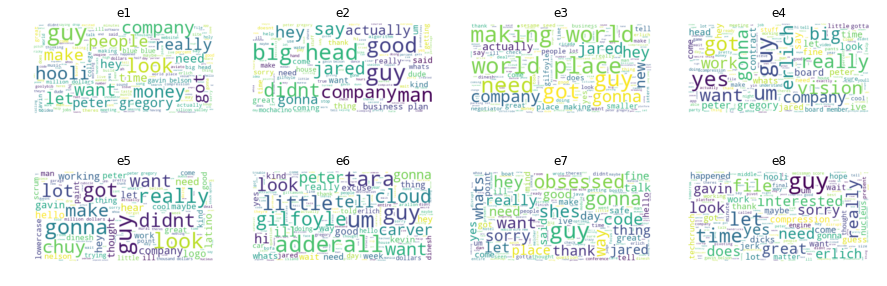

In [23]:
#Importing dependancies and creating wordclouds for each episode

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

fig = plt.figure(figsize = (15,5) )

for index , episode in enumerate(episodes):
    wordcloud = WordCloud(stopwords = words,max_font_size=50, background_color='white').generate(data.transcripts[episode])
    
    plt.subplot(2, 4, index+1)
    
    plt.imshow(wordcloud, interpolation="bilinear")
    
    plt.axis("off")
    plt.title(episode)
    
    
plt.show()


We see that some of the themes  areound which the  conversation revolves are - company, money, world, obsessed, vision, big etc. 
These words might be used by ambitious people trying to build something. Especially, in the tech industry. This is one of the reasons why I have been attracted to the show as I personally like to talk about these things too.  


Next up, lets's conduct a Sentiment Analysis on the tweets about the show and see what we can find. 

## 4.Sentiment Analysis 

In order to perform Sentiment Analysis we will be using tweepy module to collect tweets and textblob to perform analysis. 

[Tweepy Documentation](https://tweepy.readthedocs.io/en/latest/)<br>
[TextBlob Documentation](https://textblob.readthedocs.io/en/dev/)

In [24]:
import tweepy
from textblob import TextBlob

access_token = '1133364060718678017-NlAtZqnmW1XQrHiFRFaSn2pkgg9bjN'
access_token_secret = 'nwRvtguHBdlAYESq417sIbOgUiiCioHWrwye2vLCIGcBZ'
consumer_key = 'Mup6xb3v5b3mL85kmESyU4BDC'
consumer_secret = 'nr1zsiK4Mazq8H677CPUFi6C0sal4LFdtIyqDnOLCNxIbUkI0T'


In [25]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)



In [26]:
#Searching tweets containing 'Silicon Valley HBO'

public_tweets = api.search('Silicon Valley HBO', lang = 'en' , count = 100)
print(public_tweets)

[Status(_api=<tweepy.api.API object at 0x000002BCB86547F0>, _json={'created_at': 'Thu Jun 06 05:03:33 +0000 2019', 'id': 1136498842436808706, 'id_str': '1136498842436808706', 'text': 'RT @iamdevloper: Twitter, I need your help:\n\nhttps://t.co/X5nEkwWfGn\n\nGet me a cameo.\n\n@MikeJudge', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'iamdevloper', 'name': 'I Am Devloper', 'id': 564919357, 'id_str': '564919357', 'indices': [3, 15]}, {'screen_name': 'MikeJudge', 'name': 'Mike Judge', 'id': 930625267, 'id_str': '930625267', 'indices': [87, 97]}], 'urls': [{'url': 'https://t.co/X5nEkwWfGn', 'expanded_url': 'https://www.theverge.com/2019/5/31/18647697/hbo-silicon-valley-sixth-season-finale-end-mike-judge', 'display_url': 'theverge.com/2019/5/31/1864…', 'indices': [45, 68]}]}, 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'}, 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', '

In [27]:
#Getting the polarity and subjectivity for each tweet

for tweet in public_tweets:
    print(tweet.text)
    analysis = TextBlob(tweet.text)
    print(analysis.sentiment)


RT @iamdevloper: Twitter, I need your help:

https://t.co/X5nEkwWfGn

Get me a cameo.

@MikeJudge
Sentiment(polarity=0.0, subjectivity=0.0)
The treatment of Southeast Asians in the @HBO show Silicon Valley is consistently and mind-blowingly racist... like… https://t.co/UuWtHV3WgK
Sentiment(polarity=0.25, subjectivity=0.25)
Well she eventually got around to the right notes in the Canadian anthem. But the Metallica US anthem was fitting f… https://t.co/dNG7YSfSd0
Sentiment(polarity=0.39285714285714285, subjectivity=0.5178571428571428)
@jeffreyjclarke @SOMM_FILM @RoseMarie4Real Agree. Not sure what the two recent documentaries I thoroughly enjoyed m… https://t.co/1eMKGEAIqo
Sentiment(polarity=0.08333333333333333, subjectivity=0.6129629629629629)
RT @CNET: Silicon Valley to power off HBO after short final season 6 https://t.co/FEfojLmgDf https://t.co/ldXUnPuBCV
Sentiment(polarity=0.0, subjectivity=0.65)
So both Ballers and Silicon Valley won’t be showing new seasons this year, Insecure too

In [28]:
#Creating a dataframe of tweets

tweet_data = pd.DataFrame(data=[tweet.text for tweet in public_tweets], columns=['Tweets'])

display(tweet_data.sample(10))
tweet_data.shape

,Tweets
17,RT @THR: HBO's #SiliconValley to end with seas...
7,Why does she look like she's hungry for blood....
53,"RT @iamdevloper: Twitter, I need your help:\n\..."
76,HBO’s Silicon Valley will end with its sixth s...
84,"RT @iamdevloper: Twitter, I need your help:\n\..."
50,HBO's 'Silicon Valley' Cancelled After 6 Seaso...
28,RT @Variety: Say goodbye to #SiliconValley htt...
90,That Silicon Valley show on HBO is pretty good.
99,"RT @iamdevloper: Twitter, I need your help:\n\..."
38,So like this is exactly why @HBO's Silicon Val...


(100, 1)

One another approach I have used is to use **Vader Sentiment Analysis** which gives us the polarity in terms terms positive, negative , neutral and a overall compound sentiment. VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 

In [29]:


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

list = []

for index, row in tweet_data.iterrows():
    score = analyser.polarity_scores(row['Tweets'])
    list.append(score)
    
list_series = pd.Series(list)
tweet_data['polarity'] = list_series.values

display(tweet_data.head(10))

,Tweets,polarity
0,"RT @iamdevloper: Twitter, I need your help:\n\...","{'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'comp..."
1,The treatment of Southeast Asians in the @HBO ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Well she eventually got around to the right no...,"{'neg': 0.0, 'neu': 0.931, 'pos': 0.069, 'comp..."
3,@jeffreyjclarke @SOMM_FILM @RoseMarie4Real Agr...,"{'neg': 0.098, 'neu': 0.598, 'pos': 0.304, 'co..."
4,RT @CNET: Silicon Valley to power off HBO afte...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5,So both Ballers and Silicon Valley won’t be sh...,"{'neg': 0.123, 'neu': 0.877, 'pos': 0.0, 'comp..."
6,‘Silicon Valley’ To End With Abbreviated Seaso...,"{'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'comp..."
7,Why does she look like she's hungry for blood....,"{'neg': 0.0, 'neu': 0.889, 'pos': 0.111, 'comp..."
8,RT @THR: HBO's #SiliconValley to end with seas...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
9,greatly appreciated 2 things about the @hbo do...,"{'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compou..."


We can see that there is barely any negative sentiment around the show and most tweets are either neutral or positive. This might explains why the show has been very popular. 

In [30]:
#Saving the above  dataframe for future use
tweet_data.to_csv('E:\Silicon Valley\Silicon_Valley_VaderSentiment.csv')

Till now, I have tried to answer the first two of the three question I wanted to answer. For the last bit I will be repeating the same steps for TBBT and making comparisons. It will be carried out on a seperate notebook. 


Cheers, Always Blue!Always Blue!Always Blue!Always Blue! 